In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, Flatten
import h5py

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  0


In [3]:

with h5py.File("/mnt/nndataset/test3/compression/CNN_dataset.hdf5", "r") as f:
    # List all groups
    items = f.keys()               #Checks what "folders" are within the file
    print("Items in base: ", items)
    G1 = f.get('signals')   #Gets the contents of the generated data folder
    print(G1.keys())               #Checks what datasets are within the folder
    #sigs = G1.get('rx_signals')
    #print(sigs)
    #sigs = sigs[0,:,:]
    #print(sigs)
    sigs = np.array(G1.get('rx_signals')[0,:,:])
    G2 = f.get('labels')
    start = np.array(G2.get('start_index'))
    stop = np.array(G2.get('end_index'))
    
    #Gets the content of the dataset named 'signal_0' (Stored signals are in the time domain)
    #The rest of these lines also just read the data from the h5 file
    #signal_0 = np.array(G1.get('signal_0')); #signal_0 = signal_0[0:7500] 
    #signal_1 = np.array(G1.get('signal_1')); #signal_1 = signal_1[0:7500]
    #start = np.array(G1.get('starts')); #start = start[0:7500]
    #stop = np.array(G1.get('stops')); #stop = stop[0:7500]
    #angles = np.array(G1.get('angles')); #angles = angles[0:7500]
    #print(len(signal_0))
    
    
    dataset = []
    labels = []
    #dataset = dataset[0:10000]
    #print(len(dataset))
    
    print(start[0:10])
    print(stop[0:10])
    for i in range(len(sigs)):
        dataset.append(sigs[i])
        params = [start[i],stop[i]]
        labels.append(params)
    print(labels[0:10])
    
    labels = np.array(labels)
    dataset = np.array(dataset)
    
# now ready for data

allX = dataset # list of 1000-sample vectors
allY = labels # list of labels

#print(allX)

trainX = []; testX = []
trainY = []; testY = []

N = len(allX)
indexes = list(range(N))
np.random.shuffle(indexes)

M = int(N* 0.2) # 80/20 train/test split

for idx in indexes[0:M] :
    testX.append(allX[idx])
    testY.append(allY[idx])


for idx in indexes[M:] :
    trainX.append(allX[idx])
    trainY.append(allY[idx])


# ok, now we're ready to train.
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)

Items in base:  <KeysViewHDF5 ['description', 'labels', 'metadata', 'signals']>
<KeysViewHDF5 ['reference', 'rx_reference', 'rx_signals', 'tx_signals']>
[1065. 1190.  138. 1590. 1448.  543.  433. 1073. 1323. 1218.]
[2047. 1869. 1082. 2045. 2015. 1776. 1367. 1692. 1971. 1792.]
[[1065.0, 2047.0], [1190.0, 1869.0], [138.0, 1082.0], [1590.0, 2045.0], [1448.0, 2015.0], [543.0, 1776.0], [433.0, 1367.0], [1073.0, 1692.0], [1323.0, 1971.0], [1218.0, 1792.0]]


In [8]:
print(dataset.shape)


(29952, 2048)


In [ ]:
input = Input(shape=(2048,1))
# fully connected layer w/ 1 nodes
layer1 = Conv1D(filters=64, kernel_size = 2,activation="relu")(input)
layer1 = MaxPooling1D(2)(layer1)

layer2 = Conv1D(filters=128, kernel_size = 2,activation="relu")(layer1)
layer2 = MaxPooling1D(2)(layer2)

layer3 = Conv1D(filters = 128, kernel_size = 2,activation="relu")(layer2)
layer3 = MaxPooling1D(2)(layer3)

layer4 = Conv1D(filters = 512, kernel_size = 2,activation="relu")(layer3)
layer4 = MaxPooling1D(2)(layer4)

layer5 = Conv1D(filters=512, kernel_size = 2,activation="relu")(layer4)
layer5 = MaxPooling1D(3)(layer5)

layer6 = Flatten()(layer5)

layer7 = Dense(64, activation = "relu")(layer6)

output = Dense(2, activation="relu")(layer7)

# set the input and output layers
model = Model(inputs=input, outputs=output)
model.summary() # print layer info

# tell tensorflow what optimizer/loss function
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.001,
#    decay_steps=3600,
#    decay_rate=0.5)

#lr was 120000
opt = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])
      

history = model.fit(trainX, trainY, epochs=400, batch_size=500,
          validation_data=(testX, testY))

#Batch size was 100
#here we go.

training_loss = np.log10(history.history['loss'])
test_loss = np.log10(history.history ['val_loss'])

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss)
plt.plot(epoch_count, test_loss)
plt.legend(["Training Loss","Test Loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss log10(MSE)')
plt.show()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2048, 1)]         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2047, 64)          192       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1023, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1022, 128)         16512     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 511, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 510, 128)          32896     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 255, 128)          0   

In [ ]:
model.save('Time_Anechoic.h5')

CNN Output:  [  63.293224 1209.9347  ] Actual Label: [  55. 1225.]


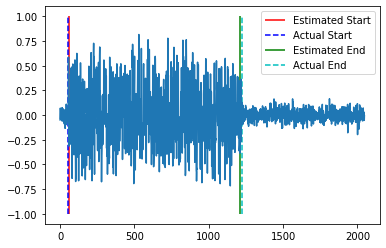

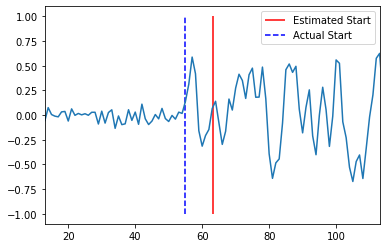

Signal value at start point:  (0.13873922745929995-0.24682364680491592j)
Signal value at start point-1:  (0.016859731656025806-0.09800177341362501j)


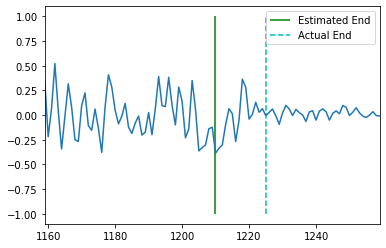

CNN Output:  [ 540.416  1200.4294] Actual Label: [ 541. 1197.]


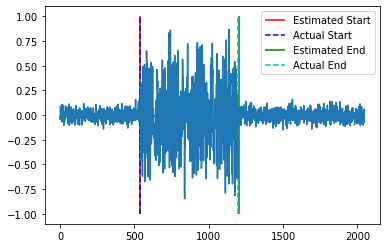

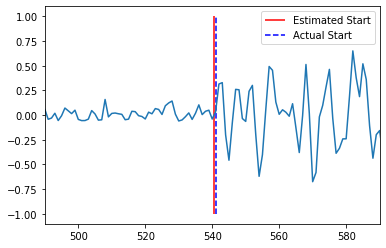

Signal value at start point:  (0.03236260021953031+0.010363964760655014j)
Signal value at start point-1:  (-0.03997219740253576+0.15021416215280198j)


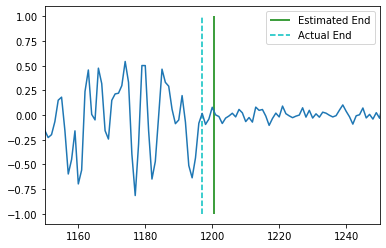

CNN Output:  [1464.4823 2025.1143] Actual Label: [1461. 2036.]


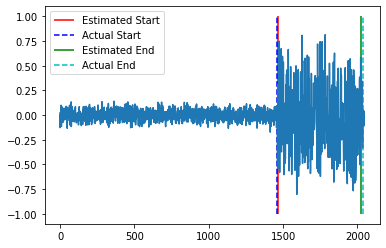

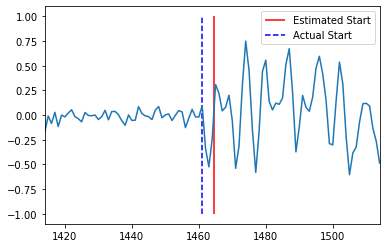

Signal value at start point:  (0.09429405039135998-0.06258604461490644j)
Signal value at start point-1:  (-0.019188288097663417+0.07913706318052988j)


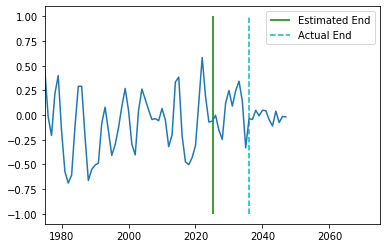

CNN Output:  [ 268.2243 1070.3196] Actual Label: [ 263. 1075.]


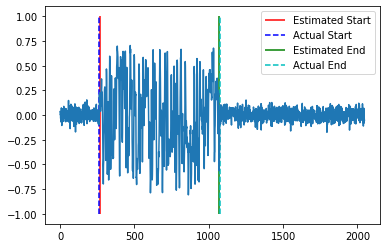

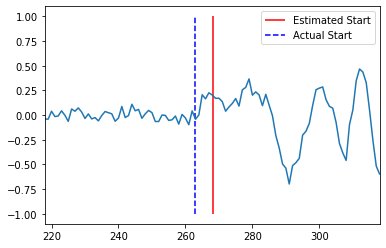

Signal value at start point:  (-0.04251050581953858+0.0404459369142493j)
Signal value at start point-1:  (0.04272699707487568-0.000509689611973993j)


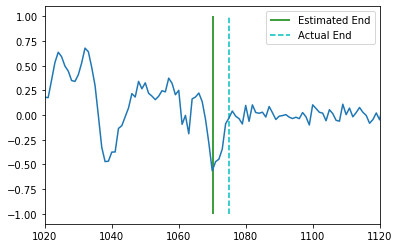

CNN Output:  [ 246.5151 1834.177 ] Actual Label: [ 250. 1829.]


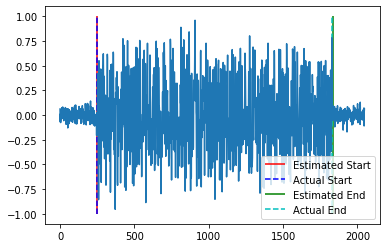

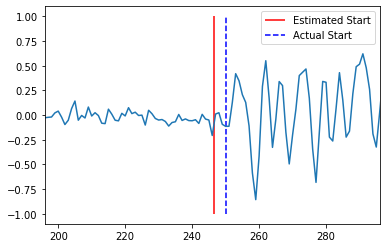

Signal value at start point:  (-0.11399131871273918+0.07316991363282342j)
Signal value at start point-1:  (-0.09319969185186819-0.059292239631783844j)


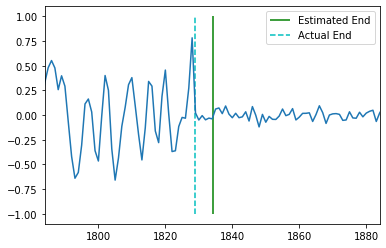

CNN Output:  [1216.7571 1761.9026] Actual Label: [1214. 1752.]


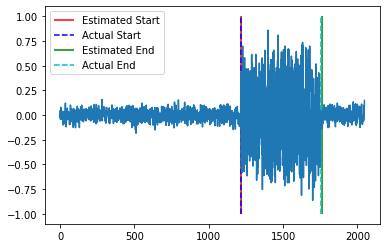

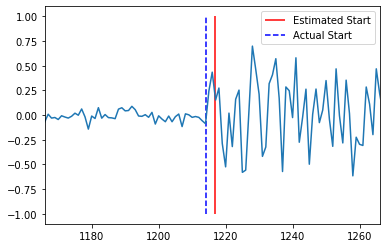

Signal value at start point:  (-0.08719135084494496+0.062232145182411096j)
Signal value at start point-1:  (-0.057123525220783324+0.021176989474517512j)


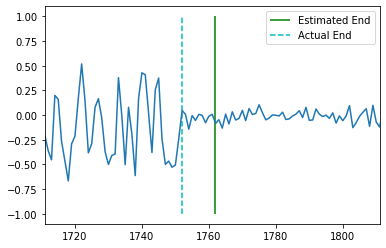

CNN Output:  [ 612.107  1935.8206] Actual Label: [ 612. 1930.]


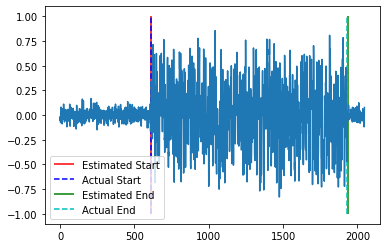

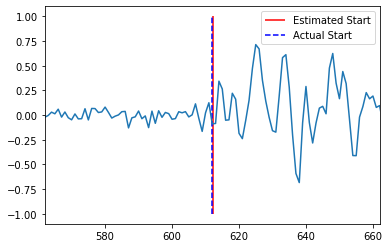

Signal value at start point:  (-0.0892582956778177-0.16095183180177694j)
Signal value at start point-1:  (0.12477791672662025+0.036077879794528214j)


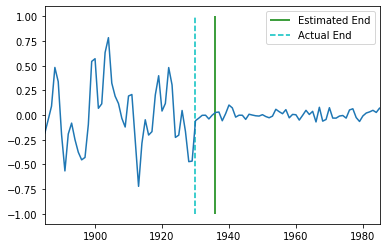

CNN Output:  [ 293.57983 1707.9426 ] Actual Label: [ 300. 1710.]


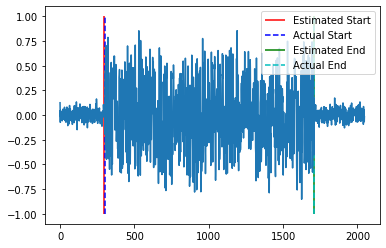

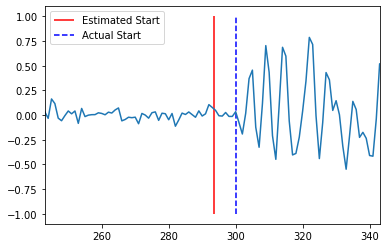

Signal value at start point:  (0.03407934647949988-0.00422776086258056j)
Signal value at start point-1:  (-0.013593489686362904+0.2143939689983895j)


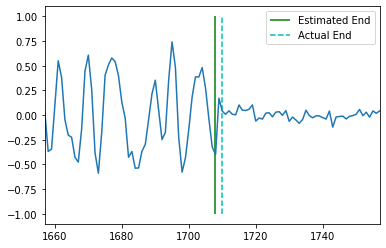

CNN Output:  [1175.7778 1923.7046] Actual Label: [1174. 1926.]


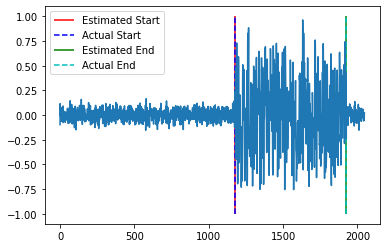

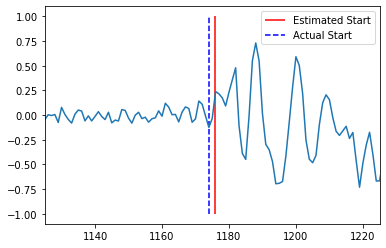

Signal value at start point:  (-0.12468243124612029-0.15116960809888955j)
Signal value at start point-1:  (-0.009117084043956919-0.12990584587608459j)


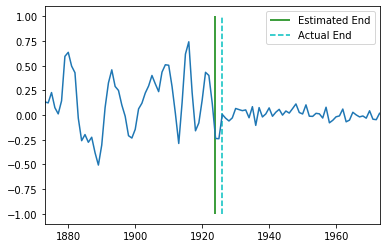

CNN Output:  [ 839.39905 1656.1332 ] Actual Label: [ 843. 1665.]


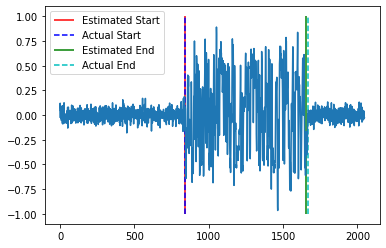

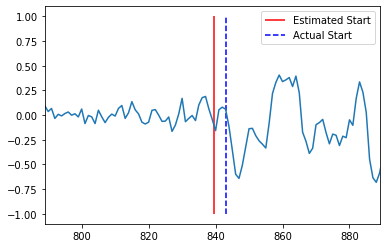

Signal value at start point:  (0.05916933682549068-0.06319357696352837j)
Signal value at start point-1:  (0.08017305675715627-0.1811532565786505j)


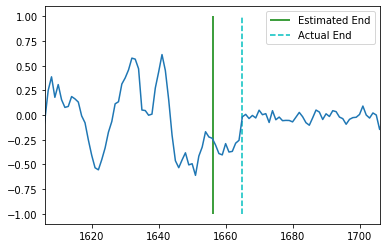

CNN Output:  [1387.3417 1875.5054] Actual Label: [1388. 1869.]


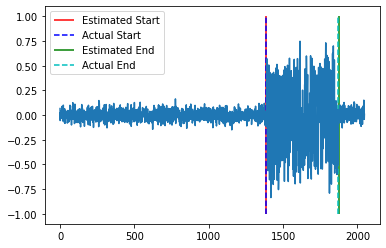

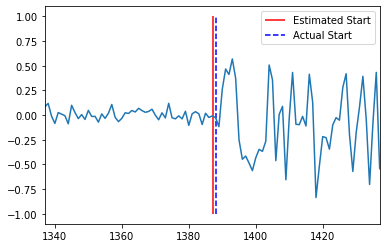

Signal value at start point:  (-0.02575621580207071-0.31282696240308744j)
Signal value at start point-1:  (-0.008782732959352382+0.09368938195844238j)


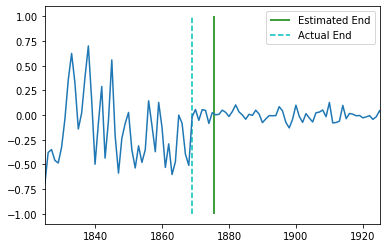

CNN Output:  [1231.9169 2016.0481] Actual Label: [1233. 2006.]


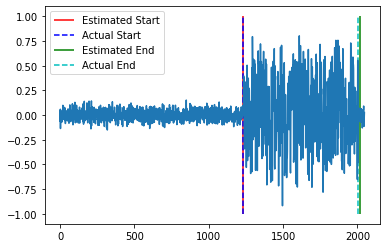

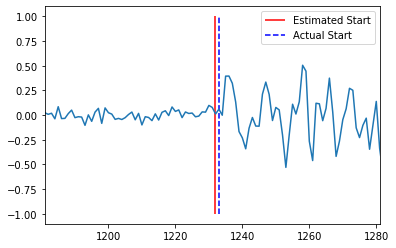

Signal value at start point:  (0.05995482040741723+0.08793300991138595j)
Signal value at start point-1:  (0.011319071686442337-0.06915026639387828j)


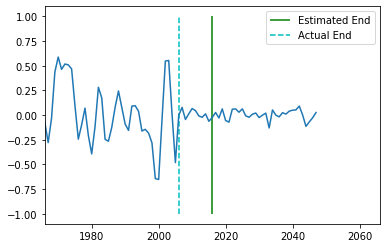

CNN Output:  [ 360.0223 1442.0793] Actual Label: [ 356. 1447.]


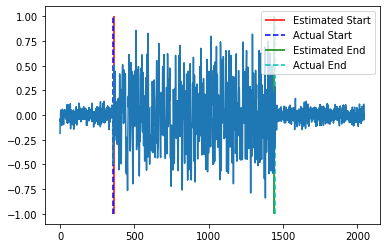

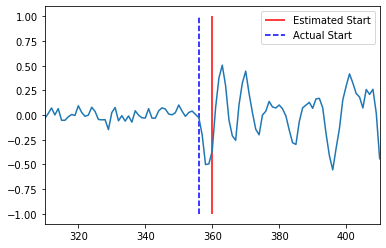

Signal value at start point:  (-0.026445454545257926-0.07506266158984028j)
Signal value at start point-1:  (0.006891784264391729+0.0637096352211031j)


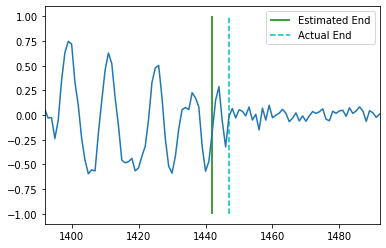

CNN Output:  [ 226.94653 1617.7432 ] Actual Label: [ 226. 1612.]


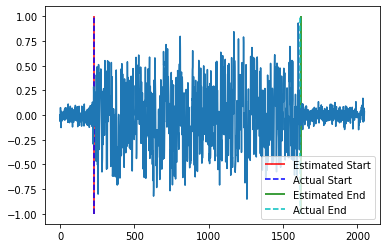

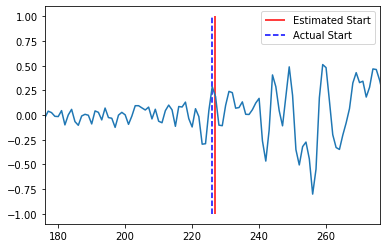

Signal value at start point:  (0.286963472394695-0.28162808108619747j)
Signal value at start point-1:  (0.047065947085360396+0.019995446093227606j)


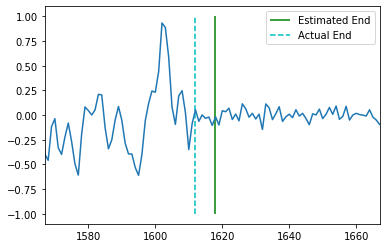

CNN Output:  [1059.8307 1633.6755] Actual Label: [1063. 1637.]


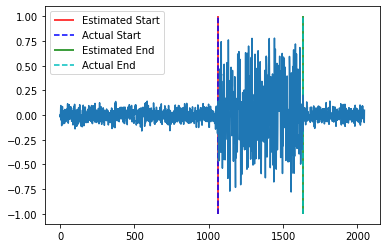

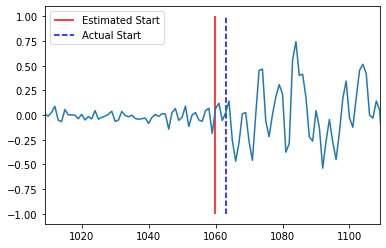

Signal value at start point:  (0.021658733286448448+0.5262790013378357j)
Signal value at start point-1:  (-0.05493895657481494-0.024061696737903156j)


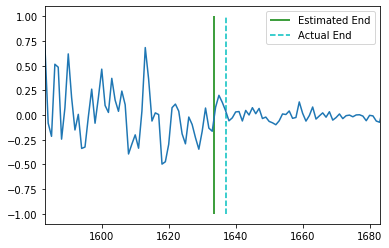

CNN Output:  [1195.0385 1828.585 ] Actual Label: [1197. 1824.]


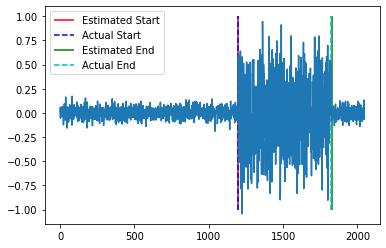

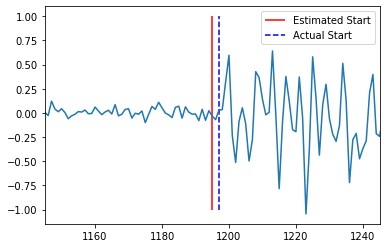

Signal value at start point:  (0.02559178419126116+0.05046452018744947j)
Signal value at start point-1:  (-0.07006817444012146+0.03910158894817105j)


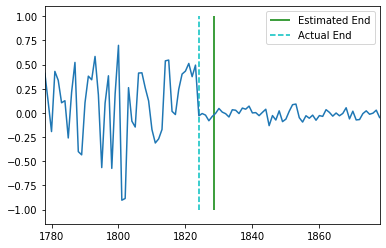

CNN Output:  [ 508.03403 1123.9667 ] Actual Label: [ 507. 1121.]


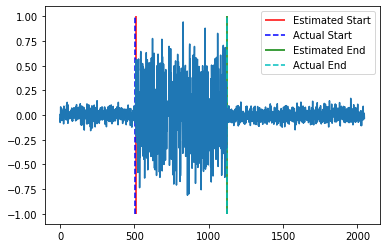

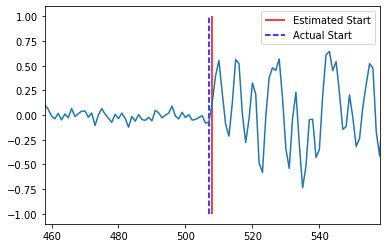

Signal value at start point:  (-0.07254952966991624-0.1331517493219766j)
Signal value at start point-1:  (-0.0814203829308211-0.06414823705711231j)


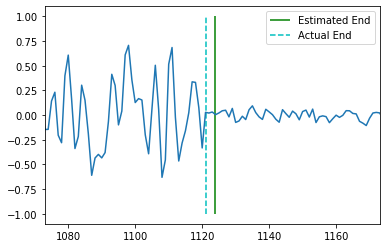

CNN Output:  [1359.4984 1952.4121] Actual Label: [1364. 1957.]


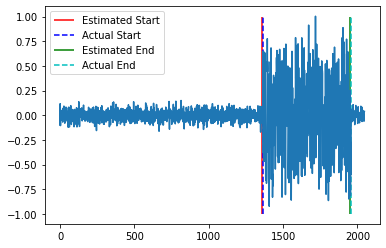

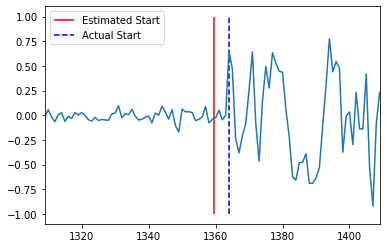

Signal value at start point:  (0.6484847865036478-0.0036772231877710312j)
Signal value at start point-1:  (-0.0026339377955866827+0.023901649232946198j)


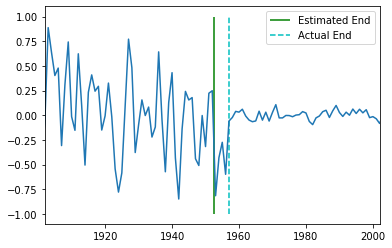

CNN Output:  [1465.291  2015.1675] Actual Label: [1461. 2006.]


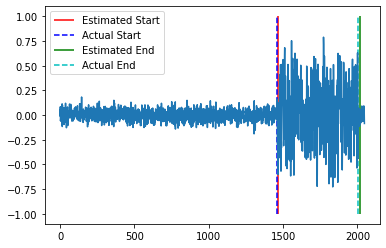

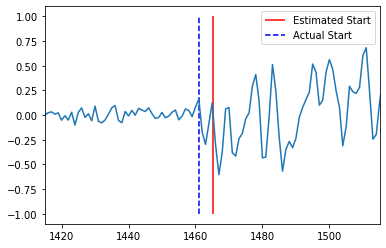

Signal value at start point:  (0.16094966930455445-0.02614993633607664j)
Signal value at start point-1:  (0.08196238582020199-0.11463485817265819j)


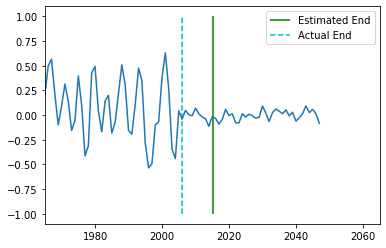

CNN Output:  [ 135.31914 2024.0004 ] Actual Label: [ 140. 2031.]


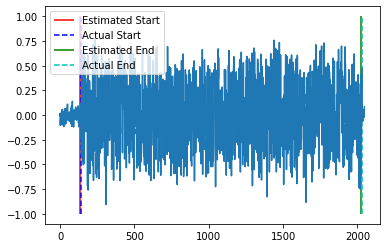

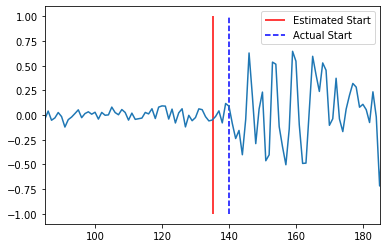

Signal value at start point:  (0.08950733655770919+0.02704706121004488j)
Signal value at start point-1:  (0.11741271775660776-0.015169839858052855j)


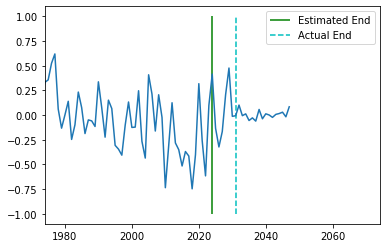

In [14]:
import warnings
warnings.filterwarnings('ignore')

load_model = keras.models.load_model("Time_CNN_Milestone_1.h5")
validatex = np.array(dataset)
validatey = np.array(labels)
#load_model.evaluate(validatex, validatey, batch_size = 300)
results = load_model.predict(testX)

for i in range(20):
    print("CNN Output: ", results[i], "Actual Label:", testY[i])
    check = int(min(testY[i]))
    signal = testX[i]
    
    """
    fig = plt.figure()
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    
    ax3.plot(range(len(test_X[i])), test_X[i])
    ax3.vlines(x=min(results[i]), ymin = -1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
    ax3.vlines(x=min(test_Y[i]), ymin = -1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
    ax3.vlines(x=max(results[i]), ymin = -1, ymax = 1, colors = 'g', linestyles = 'solid', label = 'Estimated End')
    ax3.vlines(x=max(test_Y[i]), ymin = -1, ymax = 1, colors = 'c', linestyles = 'dashed', label = 'Actual End')
    ax3.legend()
    
    x_min = int(min(results[i])-50)
    x_max = x_min + 100
    
    ax1.plot(range(len(test_X[i])), test_X[i])
    ax1.vlines(x=min(results[i]), ymin = -1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
    ax1.vlines(x=min(test_Y[i]), ymin = -1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
    ax1.set_xlim([x_min, x_max])
    ax1.legend()
    
    x_max = int(max(results[i])+50)
    x_min = x_max - 100
    
    ax2.plot(range(len(test_X[i])), test_X[i])
    ax2.vlines(x=max(results[i]), ymin = -1, ymax = 1, colors = 'g', linestyles = 'solid', label = 'Estimated End')
    ax2.vlines(x=max(test_Y[i]), ymin = -1, ymax = 1, colors = 'c', linestyles = 'dashed', label = 'Actual End')
    ax2.set_xlim([x_min, x_max])
    ax2.legend()
    
    #name = "Time_Results_" + str(i) +".png"
    #plt.savefig(name)
    #plt.show()

    """
    """
    plt.plot(range(len(testX[i])), testX[i])
    plt.vlines(x=results[i,0], ymin = -1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
    plt.vlines(x=testY[i,0], ymin = -1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
    plt.vlines(x=results[i,1], ymin = -1, ymax = 1, colors = 'g', linestyles = 'solid', label = 'Estimated End')
    plt.vlines(x=testY[i,1], ymin = -1, ymax = 1, colors = 'c', linestyles = 'dashed', label = 'Actual End')
    plt.legend()
    plt.show()
    
    x_min = int(results[i,0]-50)
    x_max = x_min + 100
    
    
    plt.plot(range(len(testX[i])), testX[i])
    plt.vlines(x=results[i,0], ymin = -1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
    plt.vlines(x=testY[i,0], ymin = -1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
    plt.xlim([x_min, x_max])
    plt.legend()
    plt.show()
    
    print("Signal value at start point: ", signal[int(testY[i,0])])
    print("Signal value at start point-1: ", signal[int(testY[i,0]-1)])
    
    x_max = int(results[i,1]+50)
    x_min = x_max - 100
    
    plt.plot(range(len(testX[i])), testX[i])
    plt.vlines(x=results[i,1], ymin = -1, ymax = 1, colors = 'g', linestyles = 'solid', label = 'Estimated End')
    plt.vlines(x=testY[i,1], ymin = -1, ymax = 1, colors = 'c', linestyles = 'dashed', label = 'Actual End')
    plt.xlim([x_min, x_max])
    plt.legend()
    plt.show()
    """